# Bikeshare Geocoding Visualization Demo

### Objectives

This analysis focuses on using 2017 Washington, DC "Capital BikeShare" trip data to show the capabilities of three Geospatial tools which are Geopandas, Ipyleaflet, and Kepler. The first two are python packages, while the latter is an open source tool developed by Uber to visualize ride demand over time. This makes it perfect for the time dependent bike ride trip data. Specific objectives are as follows...

__Geopandas__:
1. Importing basemap file
2. Geocoding, aka finding the latitude and longitude, of each station's street address
3. Placing geocoded markers for Bikshare stations

__Ipyleaflet__:
1. Create interactive "Google Maps" style visual
2. Placing customized geocoded markers for each Bikeshare station

__Kepler__
1. Export data in format friendly for tool
2. Visualize 2017 rides by day
3. Visualize 2017 rides by member type
4. Visualize 2017 rides by duration
5. Export json file of map data and visual

# Importing Libraries

In [150]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import glob
import geopandas
from geopy import Nominatim
import numpy as np
from ipyleaflet import Map, Marker
from sklearn.utils import shuffle
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')
plt.style.use('bmh')

# Reading In Data

In [152]:
#Listing the files with bikeshare data, one for each quarter
glob.glob('*tripdata.csv')

['2017Q1-capitalbikeshare-tripdata.csv',
 '2017Q2-capitalbikeshare-tripdata.csv',
 '2017Q3-capitalbikeshare-tripdata.csv',
 '2017Q4-capitalbikeshare-tripdata.csv']

Using dask will automatically concatenate the multiple files into a single dataframe.

In [153]:
#Reading in the bikeshare data to a dask dataframe
files = glob.glob('*tripdata.csv')
df = dd.read_csv(files)

#Changing the start date and end data columns to be date type objects
df['Start date'] = df['Start date'].astype('M8[us]')
df['End date'] = df['Start date'].astype('M8[us]')

#Outputting the first 5 rows
df.head()

# Using Persist to Store Data in Memory

When using dask, if the dataframe can easily fit in memory, it makes sense to use the persist function to speed up exection time by not dumping the data after each read.

In [154]:
df = df.persist().compute()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3757777 entries, 0 to 353183
Data columns (total 9 columns):
Duration                int64
Start date              datetime64[ns]
End date                datetime64[ns]
Start station number    int64
Start station           object
End station number      int64
End station             object
Bike number             object
Member type             object
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 286.7+ MB


# Geocoding Addresses

In order to use the various geospatial tools listed above, each station address will need to be geocoded. With each address only being at the street level, we need to guess a state (DC, VA, or MD). 

If the DC city address fails, try VA next, and if that fails look for MD. 

Note: (The below code allows one to find the latitude and longitude for a given address. Rather than run this everytime, I save the output to a local file and read the data in separately.)

In [7]:
#Creating the dataframe structure to store lat and long data for each address
iterables =  [['DC', 'VA', 'MD'], ['Lat', 'Long']]
idx = pd.MultiIndex.from_product(iterables)
stations = pd.DataFrame(columns=idx, index=df['Start station'].unique())

#Geolocates the location using a provided street address
geolocator = Nominatim() 

#Iterating through each address, and state as necessary
count = 0
for index, row in stations.iterrows():
    count += 1
    for state in stations.columns.levels[0]:
        location = geolocator.geocode(index + "," + state + "," + 'USA', timeout=10)
        if location is not None:
            stations.loc[index, state] = [location.latitude, location.longitude]
            break
            
    #Printing out progress
    if count % 25 == 0:
        print('Processed {} addresses.'.format(count))

Tingey Street Southeast, Navy Yard, Washington, D.C., 20388, USA
Lincoln Memorial, Lincoln Memorial Circle Northwest, Washington, D.C., 20418, USA
Henry Bacon Dr & Lincoln Memorial Circle NW, Lincoln Memorial Circle Northwest, Washington, D.C., 20418, USA
13th and H St NE, H Street Northeast, Near Northeast, Washington, D.C., 20002, USA
Adams Mill and Columbia Rd NW, Columbia Road Northwest, Washington, D.C., 20009, USA
None
None
Prince St and Union St, Prince Street, Lyles-Crouch, Alexandria, Virginia, 22314, USA
14th and R St NW, R Street Northwest, Dupont Circle, Washington, D.C., 20005:20018, USA
None
None
Capital Bikeshare;Market Square / King St and Royal St, Market Square, Jefferson Houston, Alexandria, Virginia, 22314, USA
3rd and H St NE, 3rd Street Northeast, Stanton Park, Near Northeast, Washington, D.C., 20002, USA
Lamont and Mt Pleasant NW, Mount Pleasant Street Northwest, Mount Pleasant, Washington, D.C., 20010, USA
17th & G St NW, G Street Northwest, Golden Triangle, Was

20th and O St NW / Dupont South, 20th Street Northwest, Dupont Circle and surrunding block, Washington, D.C., 20009, USA
North Capitol St & G Pl NE, North Capitol Street Northeast, NoMa, Chinatown, Washington, D.C., 20403, USA
Processed 100 addresses.
39th and Veazey St NW, 39th Street NW, Tenleytown, American University Park, D.C., 20016-2137, USA
None
None
None
Wisconsin Ave & Newark St NW, Wisconsin Avenue Northwest, Washington, D.C., 20007, USA
9th and Upshur St NW, 9th Street Northwest, Petworth, Brightwood Park, Washington, D.C., 20012, USA
2, Massachusetts Avenue Northeast, NoMa, Washington, D.C., 20002, USA
20th and L St NW, 20th Street Northwest, Golden Triangle, Washington, D.C., 20009, USA
Metro Center / 12th and G St NW, G Street Northwest, Downtown, Penn Quarter, Washington, D.C., 20005, USA
Belmont Street Northwest, Adams Morgan, Washington, D.C., 20009, USA
Connecticut Ave and Newark St NW / Cleveland Park, Newark Street Northwest, Cleveland Park, Washington, D.C., 20016

19th St and Pennsylvania Ave NW, H Street Northwest, Golden Triangle, Washington, D.C., 20006, USA
None
None
None
Gallaudet / 8th St and Florida Ave NE, Lincoln Circle, Ivy City, Washington, D.C., 20242, USA
None
None
None
None
None
Crystal City Metro / 18th and Bell St, South Bell Street, National Landing, Arlington, Arlington County, Virginia, 22202, USA
None
Army Navy Drive, Barbers Quarter, Saint Mary's County, Maryland, 20659, USA
19, E Street Northwest, Chinatown, Washington, D.C., 20001, USA
Processed 225 addresses.
10th and Monroe St NE, Monroe Street Northeast, Brookland, Washington, D.C., 20018, USA
None
None
None
None
None
None
None
Offutt Ln & Chevy Chase Dr, Offutt Lane, South Bethesda, East Bethesda, Bethesda, Montgomery County, Maryland, 20815, USA
18th and M St NW, 18th Street Northwest, Golden Triangle, Washington, D.C., 20009, USA
21, Constitution Avenue Northwest, Washington, D.C., 20004, USA
None
None
None
None
None
None
None
None
None
None
None
15th and N Scott St,

None
Woodmont Ave & Strathmore St, Woodmont Avenue, South Bethesda, East Bethesda, Bethesda, Montgomery County, Maryland, 22814, USA
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
27th and Crystal Dr, Crystal Drive, National Landing, Arlington, Arlington County, Virginia, 22202, USA
4th and D St NW / Judiciary Square, 4th Street Northwest, Chinatown, Washington, D.C., 20001, USA
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
Processed 375 addresses.
None
None
None
None
None
None
None
Montgomery County, Maryland, USA
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
Mount Vernon Ave & Four Mile Run Park, 4131, Mount Vernon Avenue, Cora Kelly, Warwick Village, Alexandria, Virginia, 22305, USA
None
None
None
Benning Branch Library, Benning Road Northeast, Marshall Heights, Washington, D.C., 20019, USA
None
None
None
Pennsylvania &

In [51]:
#Writing the output to a csv file so that running the geocoding is not necessary every time
stations.to_csv('stations_with_lat_long.csv')

In [53]:
#Reading in the stations data
stations = pd.read_csv('stations_with_lat_long.csv')

#Removing the addresses that weren't found
cleaned = stations.dropna(how='all')

#Outputting the number of addresses found in each state
cleaned.notnull().sum()

DC  Lat     196
    Long    196
VA  Lat      53
    Long     53
MD  Lat      16
    Long     16
dtype: int64

In [155]:
print("Of the", stations.shape[0], "Capital Bikeshare Stations, geopy was able to geocode", cleaned.shape[0], 'of them. For the purposes of this exercise, this success rate will suffice. Finding the locations for the unknown stations can be done through the google maps api, however this costs money.')

Of the 487 Capital Bikeshare Stations, geopy was able to geocode 265 of them. For the purposes of this exercise, this success rate will suffice. Finding the locations for the unknown stations can be done through the google maps api, however this costs money.


# Washington DC Bikeshare Stations

For the following visualization exercises, I will be constraining output to the city limits of DC.

In [156]:
#Selecting only the stations located in DC
dc_stations = cleaned['DC'].dropna()

#Setting the relevant addresses
adds = dc_stations.rename(columns={'Lat':'latitude', 'Long':'longitude'})

# Geopandas Plotting with Shapefile Basemap

Using geopandas, we can load a shapefile basemap file and plot a scatter of the DC Bikeshare station locations. Shapefiles are non-topological files used to store and visualize vector based GIS data in map format. I downloaded one of DC from the publically available resource below. 

__Washington DC ShapeFile__:
http://opendata.dc.gov/datasets/0ef47379cbae44e88267c01eaec2ff6e_31

In [158]:
#Constraining the geocodes that I am considering within DC 
min_lat = adds['latitude'] > 38.79
max_lat = adds['latitude'] < 39.01
min_long = adds['longitude'] > -77.15
max_long = adds['longitude'] < -76.8

#Creating a dataframe of DC points
constrained_adds = adds.loc[min_lat & max_lat & min_long & max_long]

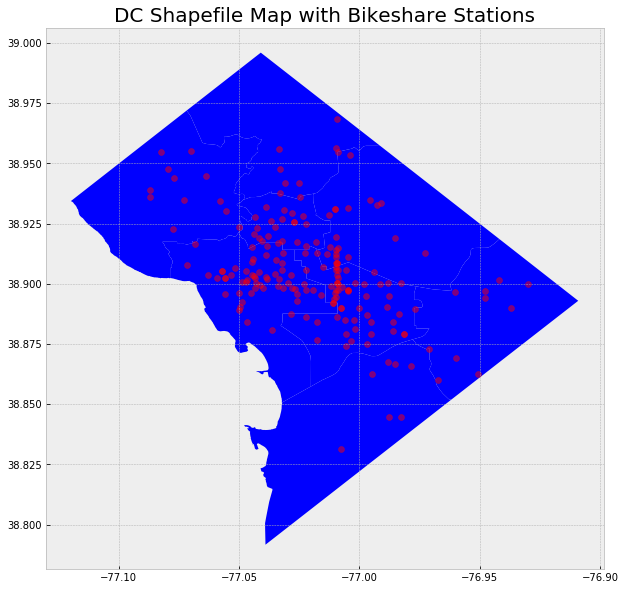

In [161]:
#Generating the map plot
gdf = geopandas.GeoDataFrame.from_file("Ward_from_2012/Ward_from_2012.shx")
gdf.plot(figsize=(10, 10))
plt.scatter(y=constrained_adds['latitude'], x=constrained_adds['longitude'], alpha=0.5, c='r')
plt.title('DC Shapefile Map with Bikeshare Stations', size=20)
plt.show();

# Plotting with Ipyleaflet

Ipyleaflet is a bridge that allows for the output of interactive maps within Jupyter notebooks. Looking online, there are not a ton of documents or videos providing detailed explanations of how to use it. Below are two examples showing how to add routes and markets to an Ipyleaflet visual. In this instance, I will be using it to again plot the DC Bikeshare stations. Each marker can have its properties individually tailored to suit the needs of the user.

__Adding Markers__:
https://ipyleaflet.readthedocs.io/en/latest/api_reference/marker.html#example

__Adding Routes__:
https://lisazhangweb.wordpress.com/2017/12/05/data-visualisation-of-route-on-map-python-tutorial/

In [97]:
#Specifying the latitutde, longitude, and zoom for the map
m = Map(center=[38.90, -77.0], zoom=11)

#Adding a marker for each individual station
for index, row in constrained_adds.iterrows():
    marker = Marker(location=[row['latitude'], row['longitude']], draggable=False)
    m.add_layer(marker)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [163]:
print('Using DC as the city for addresses, there are currently {} locations on the map. Using the boundary constraints for the city limits excludes {} locations.'.format(adds.shape[0], (len(adds) - len(constrained_adds))))

Using DC as the city for addresses, there are currently 196 locations on the map. Using the boundary constraints for the city limits excludes 3 locations.


# Dynamic Visuals With Kepler

Kepler is an open source web-app developed by Uber to visualize ride-sharing demand within cities over hours, days, months, and years. This allows them to rapidly gain insights into user behavior, communicate with outside entitites such as investors and governments, and forecast future demand. 

For use in this demonstration, I will be filtering the data to only include geocoded DC start and end stations. Due to file size upload constraints, I will be shuffling the trip dataframe and selecting the first 100,000 trips. Other resources on Kepler can be located at the following sources...

__Overviews__:

1. __From Uber__: https://eng.uber.com/keplergl/
2. __From Analytics Vidhya__: https://www.analyticsvidhya.com/blog/2018/06/ubers-kepler-gl-open-source-tool-analyzing-location-data-no-coding-required/

__Tool__: https://kepler.gl/#/

In [164]:
#Merging the trip data file with the geocoded station addresses
dc_stations_start = dc_stations.rename(columns = {'Lat':'Start_Latitude', 'Long': 'Start_Longitude'})
dc_stations_finish = dc_stations.rename(columns = {'Lat':'End_Latitude', 'Long': 'End_Longitude'})
sub1 = pd.merge(df, dc_stations_start, left_on='Start station', right_index=True)
kepler_trips = pd.merge(sub1, dc_stations_finish, left_on='End station', right_index=True)

#Dropping redundant columns
kepler_trips.drop(['Start station number', 'End station number'], axis=1, inplace=True)
kepler_trips = kepler_trips.reset_index().drop(['index'], axis=1)

#Shuffling and saving the data locally
kepler_trips = shuffle(kepler_trips)
kepler_trips[:100000].to_csv('Kepler_data.csv')

# Creating the Kepler Map

If you would like to re-create the below video in Kepler, please take the following steps.
1. Save the bikeshare data with latitude and longitude information to your local machine
2. Go to https://kepler.gl/#/
3. Click "Get Started"
4. Upload the local bikeshare file
5. Delete all layers except for "start -> end arc"
6. Click the eyeball icon next to "start -> end arc"
7. In the "Color Based On" field, select "Member Type"
8. Under Color, select type "qualitative", 3 "Steps", and the Red-Blue-Green color palette
9. Under "Stroke Based On", select Duration
10. Make the Stroke Width Range 0.5 - 5
11. Click the "Filters" Icon at the top of the window
12. Click "Add Filter"
13. Select "Start Date" as the field from the drop-down
14. Looking at the Start Date filter tool on map, drag the far right slider almost all the way left.
15. At the top right of the map, select the middle icon "3D Map"
16. Zoom out until all the bike trips are in view.
17. Click play on the "Start Date" slider. Congrats!

In case of any issue, there is a json map file provided in the Github project folder replicating the below visual that can be uploaded directly to Kepler.

# Capital Bikeshare Trip Video By Day

Using the steps above, the below video shows trips taken from start to end station, color-coded by member type, with a thickness based on individual trip duration.

In [149]:
HTML("""
<div align="middle">
<video width="90%" controls>
      <source src="Start_End_Kepler.mp4" type="video/mp4">
</video></div>""")

# Key Takeaways 

Over the course of this demonstration using actual business data from Capital Bikeshare, we were able to input and concatenate multiple files at once using dask, geocode addresses using geopy, plot a shapefile map with geopandas, plot an interactive map with Ipyleaflet, and create a dynamic time dependent visual of 2017 rides. I hope you found this content useful, and best of luck using these tools in future analysis!